<a href="https://colab.research.google.com/github/aryan-cs/poker-like-games/blob/discrete-poker/discrete_poker_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup
Run this cell to set up some helpful tools.

In [8]:
import time
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

log_data = []
P1 = True
P2 = True

RED = "#ff2684"
BLUE = "#19beff"
WHITE = "#ebebeb"
GRAY = "#858585"

# First player has n options, second player has n - 1 options (picking without replacement)
def nCr(n): return n * (n - 1) # / 2

# Saving -- irrelevant
def log(p1_cutoff, p2_cutoff, p1_expected_payout, p2_expected_payout, time_taken, verbose=True):
    log_data.append({
        'p1_cutoff': p1_cutoff,
        'p2_cutoff': p2_cutoff,
        'p1_expected_payout': p1_expected_payout,
        'p2_expected_payout': p2_expected_payout,
        'time_taken': time_taken
    })

    message = '''
P1 Cutoff: {0}
P2 Cutoff: {1}
P1 Payout: {2:.5f}
P2 Payout: {3:.5f}
Executed in {4:.5f} seconds
'''.format(p1_cutoff,
            p2_cutoff,
            p1_expected_payout,
            p2_expected_payout,
            time_taken)

    if verbose: boxed(message)

# Visual appeal -- irrelevant
def boxed(text):
    lines = text.splitlines()
    if lines and lines[0] == "": lines = lines[1:]
    if not lines: return

    max_width = max(map(len, lines))

    print("┌" + "─" * (max_width + 2) + "┐")
    for line in lines:
      print(f"│ {line.ljust(max_width)} │")
    print("└" + "─" * (max_width + 2) + "┘")

# Graphing -- irrelevant
def graph_scatter_3d(p1=False, p2=False):
    df = pd.DataFrame(log_data)
    fig = go.Figure()

    if p1:
        fig.add_trace(go.Scatter3d(
            x=df['p1_cutoff'],
            y=df['p2_cutoff'],
            z=df['p1_expected_payout'],
            mode='markers',
            marker=dict(color='blue', size=4),
            name='Player 1'
        ))

    if p2:
        fig.add_trace(go.Scatter3d(
            x=df['p1_cutoff'],
            y=df['p2_cutoff'],
            z=df['p2_expected_payout'],
            mode='markers',
            marker=dict(color='red', size=4),
            name='Player 2'
        ))

    fig.update_layout(
        title='Payouts as a function of Cutoffs | Scatter',
        scene=dict(
            xaxis_title='P1 Cutoff',
            yaxis_title='P2 Cutoff',
            zaxis_title='Payout'
        ),
        showlegend=True
    )

    fig.show()

# Graphing -- irrelevant
def graph_contour_3d(p1=False, p2=False):
    df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()
    fig = go.Figure()

    x = np.unique(df['p1_cutoff'])
    y = np.unique(df['p2_cutoff'])
    X, Y = np.meshgrid(x, y)

    if p1:
        Z1 = df.pivot_table(
            index='p2_cutoff',
            columns='p1_cutoff',
            values='p1_expected_payout').values
        fig.add_trace(go.Surface(x=X, y=Y, z=Z1,
                                 colorscale='Blues',
                                 opacity=0.9,
                                 name="Player 1 Payout"))

    if p2:
        Z2 = df.pivot_table(
            index='p2_cutoff',
            columns='p1_cutoff',
            values='p2_expected_payout').values
        fig.add_trace(go.Surface(x=X, y=Y, z=Z2,
                                 colorscale='Reds',
                                 opacity=0.9,
                                 name="Player 2 Payout"))

    fig.update_layout(
        title='Payouts as a function of Cutoffs | Contour',
        scene=dict(
            xaxis_title='P1 Cutoff',
            yaxis_title='P2 Cutoff',
            zaxis_title='Payout'
        ),
        showlegend=True
    )

    fig.show()

# Displaying payoff matrix -- irrelevant
def expected_payoffs_table(p1=False, p2=False):
    if p1 and p2:
        boxed("Please use only one flag per table.")
        return

    console = Console()
    df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()

    if p1:
        pivot = df.pivot(index='p1_cutoff', columns='p2_cutoff', values='p1_expected_payout')
        title = "E(c1, c2) for P1 | " + str(n) + " x " + str(n)
    elif p2:
        pivot = df.pivot(index='p1_cutoff', columns='p2_cutoff', values='p2_expected_payout')
        title = "E(c1, c2) for P2 | " + str(n) + " x " + str(n)
    else:
        boxed("Please specify either p1=True or p2=True")
        return

    table = Table(title=title, show_lines=True, padding=(0, 1), collapse_padding=True)
    table.add_column("C", style=WHITE, justify="right")

    for col in pivot.columns:
        table.add_column(f"{col}", justify="right")

    def format_value(val):
        if pd.isnull(val):
            return f"[#ebebeb]-[/#ebebeb]"
        color = BLUE if val > 0 else RED if val < 0 else WHITE
        formatted_val = f"{int(val)}" if val == int(val) else f"{val:.5f}"
        return f"[{color}]{formatted_val}[/{color}]"

    for idx, row in pivot.iterrows():
        idx_formatted = f"{int(idx)}" if idx == int(idx) else f"{idx:.2f}"
        table_row = [idx_formatted] + [format_value(val) for val in row]
        table.add_row(*table_row, end_section=True)

    console.print(table)

def graph_2d():
  df = pd.DataFrame(log_data).groupby(['p1_cutoff', 'p2_cutoff'], as_index=False).mean()
  plt.figure(figsize=(10, 6))
  plt.plot(df['p1_cutoff'],df['p1_expected_payout'])

# Exporting -- irrelevant
def save():
    df = pd.DataFrame(log_data)
    df.to_csv('data.csv', index=False)


# 1. Simulation
Simulating payoffs for various cutoff combinations.

┌───────────────────────────────────────────┐
│ Executed all iterations in 0.012 seconds. │
└───────────────────────────────────────────┘


            E(c1, c2) for P1 | 10 x 10             
┏━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━┳━━━┳━━━┳━━━┳━━━┓
┃  C ┃  1 ┃  2 ┃  3 ┃  4 ┃  5 ┃ 6 ┃ 7 ┃ 8 ┃ 9 ┃10 ┃
┡━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━╇━━━╇━━━╇━━━╇━━━┩
│  1 │  0 │ -9 │-14 │-15 │-12 │-5 │ 6 │21 │40 │63 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│  2 │  9 │  0 │ -8 │-12 │-12 │-8 │ 0 │12 │28 │48 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│  3 │ 14 │  8 │  0 │ -7 │-10 │-9 │-4 │ 5 │18 │35 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│  4 │ 15 │ 12 │  7 │  0 │ -6 │-8 │-6 │ 0 │10 │24 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│  5 │ 12 │ 12 │ 10 │  6 │  0 │-5 │-6 │-3 │ 4 │15 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│  6 │  5 │  8 │  9 │  8 │  5 │ 0 │-4 │-4 │ 0 │ 8 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│  7 │ -6 │  0 │  4 │  6 │  6 │ 4 │ 0 │-3 │-2 │ 3 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│  8 │-21 │-12 │ -5 │  0 │  3 │ 4 │ 3 │ 0 │-2 │ 0 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│  9 │-40 │-28 │-18 │-10 │ -4 │ 0 │ 2 │ 2 │ 0 │-1 │
├────┼────┼────┼────┼────┼────┼───┼───┼───┼───┼───┤
│ 10 │-63 │-48 │-35 │-24 │-15 │-8 │-3 │ 0 │ 1 │ 0 │
└────┴────┴────┴────┴────┴────┴───┴───┴───┴───┴───┘

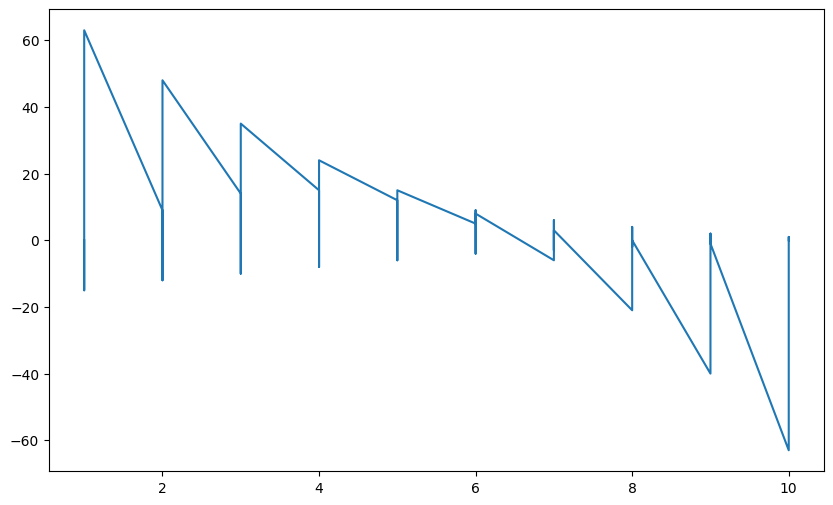

In [10]:
#@title { vertical-output: true }

"""

  Example n values:
    n = 3: Ace/King/Queen
    n = 6: Dice
    n = 13: Full Suit Poker
    n = 1000: Roughly continuous

  Iterating for cutoff ranges of [1, test_range]

"""
n = 10
test_range = n
p1_expected_payout, p2_expected_payout = 0, 0
trials = nCr(n)

def test_cutoffs(p1_cutoff, p2_cutoff):

  start_time = time.time()

  global p1_expected_payout
  global p2_expected_payout

  p1_expected_payout = 0
  p2_expected_payout = 0

  # Testing every possible 'card' for P1 and P2
  for p1_card in range(1, n + 1):
    for p2_card in range(1, n + 1):

      if p1_card == p2_card: continue

      # P1 in betting region, P2 in betting region
      if p1_card >= p1_cutoff and p2_card >= p2_cutoff:

        if p1_card > p2_card:       # P1 wins showdown
          p1_expected_payout += 2
          p2_expected_payout -= 2
        else:                       # P2 wins showdown
          p1_expected_payout -= 2
          p2_expected_payout += 2

      # P1 in folding region, P2 in folding region
      elif p1_card < p1_cutoff and p2_card < p2_cutoff:

        if p1_card > p2_card:       # P1 wins showdown
          p1_expected_payout += 1
          p2_expected_payout -= 1
        else:                       # P2 wins showdown
          p1_expected_payout -= 1
          p2_expected_payout += 1

      # P1 in betting region, P2 in folding region | P2 forfeits, P1 wins be default
      elif p1_card >= p1_cutoff:
        p1_expected_payout += 1
        p2_expected_payout -= 1

      # P1 in folding region, P2 in betting region | P1 forfeits, P2 wins be default
      elif p2_card >= p2_cutoff:
        p1_expected_payout -= 1
        p2_expected_payout += 1

  return time.time() - start_time

log_data = []
start_time = time.time()

'''
  Testing all possible cutoffs
  A cutoff is defined as the minimum value a player must have in order to bet
'''
for p1_test_cutoff in range(1, test_range + 1):
  for p2_test_cutoff in range(1, test_range + 1):
    timeTaken = test_cutoffs(p1_test_cutoff, p2_test_cutoff)
    log(p1_test_cutoff,
        p2_test_cutoff,
        # p1_expected_payout / trials,
        # p2_expected_payout / trials,
        p1_expected_payout,
        p2_expected_payout,
        timeTaken,
        verbose=False)

boxed(f"Executed all iterations in {round(time.time() - start_time, 3)} seconds.\n")

# Add flags as necessary (P1, P2)
# graph_scatter_3d(P1)
# graph_contour_3d(P1)
graph_2d()
expected_payoffs_table(P1)
save()